In [257]:
import pyhf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyhf.contrib.viz import brazil
from cabinetry.model_utils import prediction
from pyhf.contrib.utils import download
import json
import cabinetry

In [258]:
#cabinetry.set_logging()
cabinetry_config = cabinetry.configuration.load("config.yaml")
cabinetry.configuration.print_overview(cabinetry_config)

INFO - cabinetry.configuration - opening config file config.yaml
INFO - cabinetry.configuration - the config contains:
INFO - cabinetry.configuration -   5 Sample(s)
INFO - cabinetry.configuration -   1 Regions(s)
INFO - cabinetry.configuration -   4 NormFactor(s)


In [259]:
cabinetry.templates.collect(cabinetry_config, method="uproot")

DEBUG - cabinetry.route -   in region Signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.templates.collector - region override specified, but {RegionPath} not found in default path
DEBUG - cabinetry.histo - saving histogram to ../data/Signal_region_Data.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.templates.collector - region override specified, but {RegionPath} not found in default path
DEBUG - cabinetry.histo - saving histogram to ../data/Signal_region_Signal.npz
DEBUG - cabinetry.route -     reading sample Bu_Dststmunu
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.templates.collector - region override specified, but {RegionPath} not found in default path
DEBUG - cabinetry.histo - saving histogram to ../data/Signal_region_Bu_Dststmunu.npz
DEBUG - cabinetry.route -     reading sample Bu_DstD
DEBUG - 

In [260]:
workspace_path = "workspaces/example_workspace.json"
ws = cabinetry.workspace.build(cabinetry_config)
cabinetry.workspace.save(ws, workspace_path)
sample_list = []
# Normalise each of the templates so the normalisation factor is the component yield
for _c in range(len(ws['channels'][0]['samples'])):
    sample_list.append(ws['channels'][0]['samples'][_c]['name'])
    normfactor = np.sum(ws['channels'][0]['samples'][_c]['data'])
    ws['channels'][0]['samples'][_c]['data'] /= normfactor
    ws['channels'][0]['samples'][_c]['data'] = ws['channels'][0]['samples'][_c]['data'].tolist()
    ws['channels'][0]['samples'][_c]['modifiers'][0]['data'] /= normfactor
    ws['channels'][0]['samples'][_c]['modifiers'][0]['data'] = ws['channels'][0]['samples'][_c]['modifiers'][0]['data'].tolist()
print(sample_list)

INFO - cabinetry.workspace - building workspace
WARNING - cabinetry.histo - the modified histogram ../data/Signal_region_Signal_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
DEBUG - cabinetry.workspace - adding NormFactor Bd_Dstmu_norm to sample Signal in region Signal_region
WARNING - cabinetry.histo - the modified histogram ../data/Signal_region_Bu_Dststmunu_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
DEBUG - cabinetry.workspace - adding NormFactor Bu_Dststmunu_norm to sample Bu_Dststmunu in region Signal_region
WARNING - cabinetry.histo - the modified histogram ../data/Signal_region_Bu_DstD_modified.npz does not exist
WARNING - cabinetry.histo - loading the un-modified histogram instead!
DEBUG - cabinetry.workspace - adding NormFactor Bu_DstD_norm to sample Bu_DstD in region Signal_region
WARNING - cabinetry.histo - the modified histogram ../data/Signal_region_Combinatorial_mo

['Signal', 'Bu_Dststmunu', 'Bu_DstD', 'Combinatorial']


INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier Bu_DstD_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier Bu_Dststmunu_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier comb_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier Bd_Dstmu_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_Signal_region (50 new nuisance parameters)
INFO - cabinetry.visualize.utils - saving figure as figures/modifier_grid.pdf


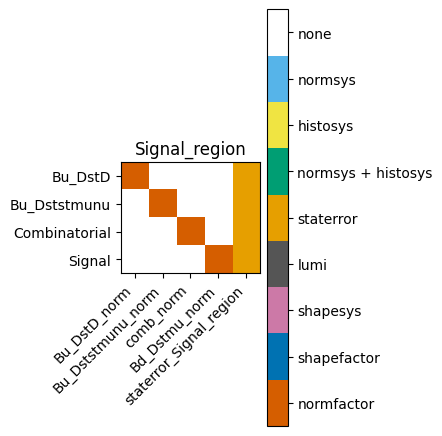

In [235]:
#ws = cabinetry.workspace.load(workspace_path)
toyFit = False
model, data = cabinetry.model_utils.model_and_data(ws, asimov = toyFit)
if toyFit:
    data[:50] = np.random.poisson(data[:50])
cabinetry.visualize.modifier_grid(model)

In [236]:
fit_results = cabinetry.fit.fit(model, data)
print(model)

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 369.4                      │             Nfcn = 5836              │
│ EDM = 1.03e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


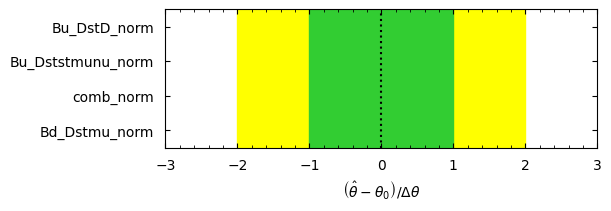

In [237]:
cabinetry.visualize.pulls(fit_results, exclude=["Signal_norm"])

INFO - cabinetry.visualize.utils - saving figure as figures/Signal_region_prefit.pdf


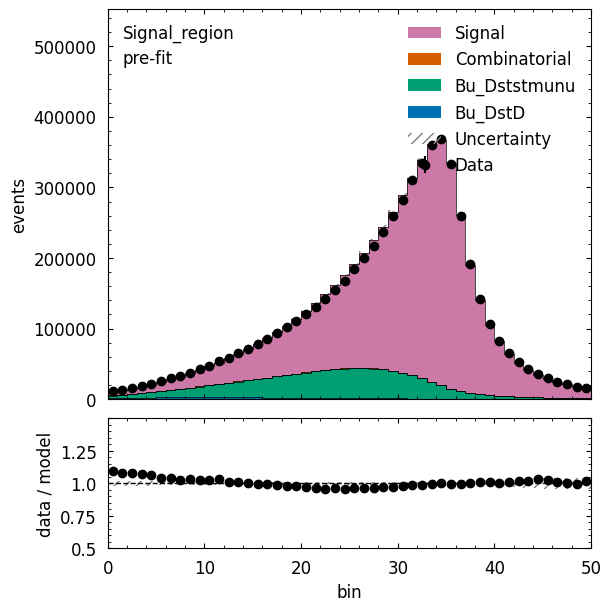

In [238]:
model_pred = cabinetry.model_utils.prediction(model)
figures = cabinetry.visualize.data_mc(model_pred, data, config=cabinetry_config)

INFO - cabinetry.visualize.utils - saving figure as figures/Signal_region_postfit.pdf


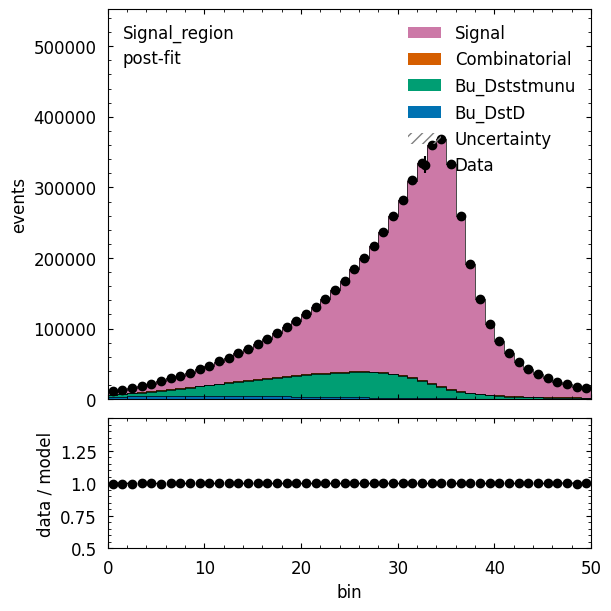

In [239]:
model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_pred_postfit, data, config=cabinetry_config)

/tmp/ipykernel_295944/711524404.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([' '] + ticklabels)
/tmp/ipykernel_295944/711524404.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([' '] + ticklabels)
/tmp/ipykernel_295944/711524404.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


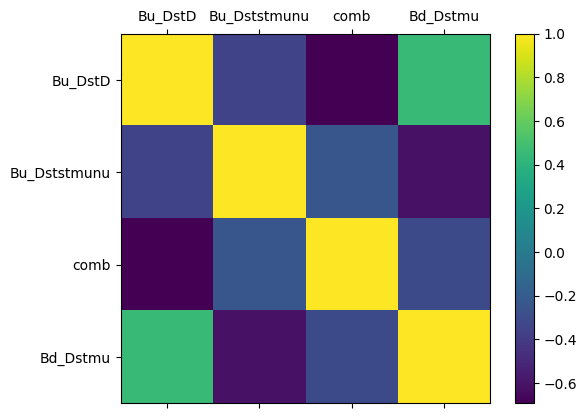

In [255]:
ticklabels = [_l.strip('_norm') for _l in fit_results.labels[:4]]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(fit_results.corr_mat[:4,:4], interpolation='nearest')
fig.colorbar(cax)
ax.set_xticklabels([' '] + ticklabels)
ax.set_yticklabels([' '] + ticklabels)
fig.show()

In [256]:
myplt = cabinetry.visualize.correlation_matrix(fit_results)
plt.show()

INFO - cabinetry.visualize.utils - saving figure as figures/correlation_matrix.pdf
